# UZDEVUMI

Šo uzdevumu izpildei nav nepieciešama situācijas analīze kartē vai manuāla ģeometrijas rediģēšana, tāpēc efektīvākai pieejai izvēlēšos Python, kas nodrošina pārskatāmu darbību izpildi un ļauj ērti veikt izmaiņas vai atkārtot procesus. Savukārt interaktīvās kartes izveidei izmantošu React Leaflet.

#### Izmantotie dati.
Latvijas Atvērto datu portāls.<br>
Valsts adrešu reģistra atvērtie dati: https://data.gov.lv/dati/lv/dataset/varis-atvertie-dati \
Biotopi: https://data.gov.lv/dati/lv/dataset/aizsargajamas-dzivotnes-biotopi \
Mikroliegumi: https://data.gov.lv/dati/lv/dataset/mikroliegumi<br><br>
LĢIA publiskā Vietvārdu datubāze: [saite](https://vietvardi.lgia.gov.lv/search?id=0&regionaID=0&rajonaID=0&veidi=purvs&nosaukDala=&nosExact=false&citataDala=false&nosOficial=false&nosNonAccent=false&nosLGIAApproved=false&sortInfo=1)<br>
Kadastra telpiskie dati no ArcGIS platformas<br>

In [2]:
import pandas as pd
import numpy as np
import geopandas

import fiona

from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# (1) Mikroliegumu pārskata karte


In [4]:
# Lejupielādēju Valsts adrešu reģistra atvērtos telpiskos datus

zip_data = 'aw_shp.zip'

with ZipFile(zip_data, 'r') as archive:
    file_list = archive.namelist()


# Lai kartē būtu iespējams atsevišķi iekrāsot teritorijas bez mikroliegumiem, klāt pie novadiem pievienošu valstspilsētas
novadi = geopandas.read_file(f'zip://{zip_data}!{'Novadi.shp'}')
valstspilsētas = geopandas.read_file(f'zip://{zip_data}!{'Pilsetas.shp'}')

# Izdalu tās valstspilsētas, kuras nav novadu teritoriālā iedalījuma vienības
valstspilsētas = valstspilsētas.loc[~(
    valstspilsētas['STD'].str.contains('nov.', regex=False) | valstspilsētas['STD'].str.contains('pag.', regex=False))]

# Pievienoju 7 valstspilsētas pie novadu teritorijām
novadi = pd.concat([novadi, valstspilsētas], ignore_index=True)

novadi.head(3)

,KODS,TIPS_CD,NOSAUKUMS,VKUR_CD,VKUR_TIPS,APSTIPR,APST_PAK,STATUSS,SORT_NOS,DAT_SAK,DAT_MOD,DAT_BEIG,ATRIB,STD,geometry
0,100016421,113,Jēkabpils nov.,100000000,101,Y,252,EKS,Jēkabpils novads,2021.07.01,30.06.2021 17:39:21,None,0031000,Jēkabpils nov.,"POLYGON ((648780.755 278157.384, 649193.907 27..."
1,100016286,113,Valkas nov.,100000000,101,Y,252,EKS,Valkas novads,2009.07.01,03.08.2022 00:00:00,None,0053000,Valkas nov.,"POLYGON ((622604.168 380954.353, 622574.825 38..."
2,100016542,113,Rēzeknes nov.,100000000,101,Y,252,EKS,Rēzeknes novads,2021.07.01,30.06.2021 17:43:50,None,0043000,Rēzeknes nov.,"POLYGON ((706963.768 234461.549, 706918.09 234..."


In [5]:
# Aprēķinu novadu teritoriju platību kvadrātmetros
novadi['Novada platība'] = novadi['geometry'].area.astype('int64')

# Saglabāju tikai nepieciešamās kolonnas un pārdēvēju nosaukumu
novadi = novadi[['STD', 'Novada platība', 'geometry']]
novadi = novadi.rename(columns={'STD': 'Novads'})

novadi.head(3)

,Novads,Novada platība,geometry
0,Jēkabpils nov.,2994664907,"POLYGON ((648780.755 278157.384, 649193.907 27..."
1,Valkas nov.,908402345,"POLYGON ((622604.168 380954.353, 622574.825 38..."
2,Rēzeknes nov.,2811361559,"POLYGON ((706963.768 234461.549, 706918.09 234..."


In [6]:
# Lejupielādēju mikroliegumu telpiskos datus

zip_mikroliegumi = 'mikroliegumi.zip'

with ZipFile(zip_mikroliegumi, 'r') as archive:
    file_list = archive.namelist()

file_list

['Mikroliegumi/Mikroliegumi.cpg',
 'Mikroliegumi/Mikroliegumi.dbf',
 'Mikroliegumi/Mikroliegumi.prj',
 'Mikroliegumi/Mikroliegumi.sbn',
 'Mikroliegumi/Mikroliegumi.sbx',
 'Mikroliegumi/Mikroliegumi.shp',
 'Mikroliegumi/Mikroliegumi.shp.xml',
 'Mikroliegumi/Mikroliegumi.shx',
 'Mikroliegumi/MikroliegumuBuferzonas.cpg',
 'Mikroliegumi/MikroliegumuBuferzonas.dbf',
 'Mikroliegumi/MikroliegumuBuferzonas.prj',
 'Mikroliegumi/MikroliegumuBuferzonas.sbn',
 'Mikroliegumi/MikroliegumuBuferzonas.sbx',
 'Mikroliegumi/MikroliegumuBuferzonas.shp',
 'Mikroliegumi/MikroliegumuBuferzonas.shp.xml',
 'Mikroliegumi/MikroliegumuBuferzonas.shx']

In [7]:
# Ielādēju mikroliegumu ShapeFile
mikroliegumi = geopandas.read_file(f'zip://{zip_mikroliegumi}!{'Mikroliegumi/Mikroliegumi.shp'}')
mikroliegumi.head(3)

,ID,MR_OBJECT,BUFFERZONE,APPL_DATE,EXPERT_DAT,FROM_DATE,AREA_DOC,MRCODE,MR_TYPE,GlobalID,ATIS_CODE,ATIS_veids,Shape_Leng,Shape_Area,geometry
0,1,2,0,2001-11-27,2001-11-27,2002-11-22,7.0,47,10,{BECCDA9A-A2B7-48AD-A483-F8C6A8E2EFC2},7313100100,Mikrolieguma teritorija,5008.917622,71609.151391,"POLYGON ((550479.299 253044.071, 550495.915 25..."
1,7,3,1,2011-01-31,2011-01-31,2011-06-07,12.5,2058,4,{5AF4533E-1B0F-4811-8A89-CBEDBF5E9296},7313100100,Mikrolieguma teritorija,1883.815289,125292.344500,"POLYGON ((409814.21 279043.14, 409830.71 27897..."
2,11,3,1,2010-03-23,2008-03-23,2011-04-15,26.8,2054,4,{6AD8E97F-A9C0-467B-810E-EE2AE0FF1631},7313100100,Mikrolieguma teritorija,2306.468835,275353.545150,"POLYGON ((534651.32 334765.92, 534655.52 33461..."


In [8]:
# Sadalu mikroliegumu teritorijas pa novadu robežām (telpiska pārklāšanās)
mikroliegumi_novados = mikroliegumi.overlay(novadi, how='intersection', keep_geom_type=False)

# Atlasu nepieciešamās kolonnas
mikroliegumi_novados = mikroliegumi_novados[['Novads', 'Novada platība', 'geometry']]

# Apvienoju mikroliegumus pēc novadiem, summējot platības
mikroliegumi_novados = mikroliegumi_novados.dissolve('Novads', as_index=False)

# Aprēķinu mikroliegumu platību novados kvadrātmetros 
mikroliegumi_novados['Mikroliegumu platība novadā'] = mikroliegumi_novados['geometry'].area.astype('int64')

# Aprēķinu mikroliegumu procentuālo īpatsvaru katrā novadā
mikroliegumi_novados['Procentuālais īpatsvars'] = \
            ((mikroliegumi_novados['Mikroliegumu platība novadā'] / mikroliegumi_novados['Novada platība']) * 100).round(3)

mikroliegumi_novados.head(3)

,Novads,geometry,Novada platība,Mikroliegumu platība novadā,Procentuālais īpatsvars
0,Aizkraukles nov.,"MULTIPOLYGON (((563562.042 239301.269, 563563....",2272825567,25978856,1.143
1,Alūksnes nov.,"MULTIPOLYGON (((681819.64 354478.88, 681833.34...",1697720266,35162502,2.071
2,Augšdaugavas nov.,"MULTIPOLYGON (((634642.21 194442.72, 634632.99...",2523093354,7388318,0.293


In [9]:
# Apvienoju aprēķinātos datus ar novadu ģeometriju, lai sagatavotu datus kartei
dati_kartei = novadi.merge(mikroliegumi_novados[['Novads', 'Procentuālais īpatsvars']], how='outer', on='Novads')

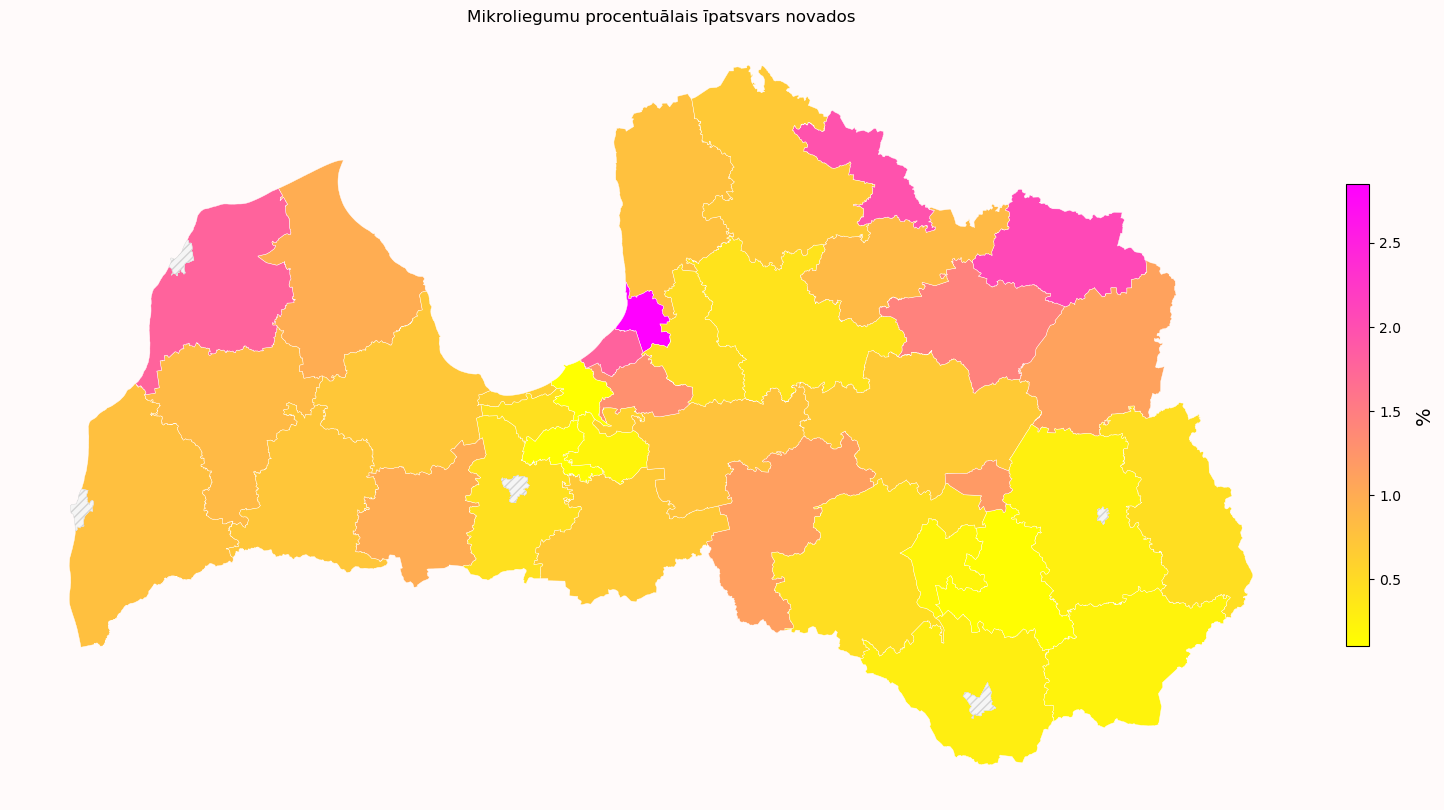

,Novads,Procentuālais īpatsvars
0,Saulkrastu nov.,2.848
1,Alūksnes nov.,2.071
2,Valkas nov.,1.963
3,Ādažu nov.,1.789
4,Ventspils nov.,1.784
5,Gulbenes nov.,1.454
6,Ropažu nov.,1.302
7,Varakļānu nov.,1.189
8,Aizkraukles nov.,1.143
9,Balvu nov.,1.110


In [11]:
# Izveidoju karti un tabulu ar mikroliegumu procentuālo īpatsvaru novadu griezumā

fig, ax = plt.subplots(figsize=(22,10), facecolor = 'Snow')

dati_kartei.plot(
    column='Procentuālais īpatsvars', 
    cmap='spring_r', 
    ax=ax, 
    linewidth=0.3,
    edgecolor="white",
    missing_kwds={
        "color": "WhiteSmoke",
        "edgecolor": "LightGrey", 
        "hatch": "////",
    },
)

cbar = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6, aspect=20, pad=0.02)
cbar.set_label('%', labelpad=10, fontsize=14)

ax.axis('off')
plt.title('Mikroliegumu procentuālais īpatsvars novados')

plt.show()




# Izveidoju tabulu ar aprēķinātajiem mikroliegumu procentiem
dati_kartei[['Novads', 'Procentuālais īpatsvars']] \
        .sort_values('Procentuālais īpatsvars', ascending=False) \
        .reset_index(drop=True)

# (2) Topoloģijas kļūdu pārskats



In [12]:
# Ielādēju ArcGIS ģeodatubāzi (.gdb)
gdb_path = 'kartografu_parbaude/parbaude_kart/parbaude/dap.gdb'

# Pārskatu pieejamos slāņus
layers = fiona.listlayers(gdb_path)
layers

['Microreserves', 'TOPO', 'Microres_bufferzones']

In [13]:
# Ielādēju 'TOPO' slāni
topo = geopandas.read_file(gdb_path, layer='TOPO')

In [14]:
# Pārbaudu, vai ir kādi objekti ar dublētām ģeometrijām
topo.loc[topo['geometry'].duplicated()].shape[0]

0

***Dublētās ģeometrijas neatrodu***

In [15]:
# Pārbaudu ģeometriju derīgumu (vai nav ģeometriskas kļūdas)
topo['geometry'].is_valid_reason()

0                                    Valid Geometry
1    Ring Self-intersection[590090.366 298456.2985]
dtype: object

***Kļūda atrasta – pašu krustojošās līnijas***

In [16]:
# Pārbaudu, vai objekti pārklājas savā starpā

# Izfiltrēju objektu pārklāšanās gadījumus, tai skaitā mazos nevēlamos attalumus, kuri bieži rodas nepilnīgu robežu dēļ
topo['uid'] = topo.index
parklajumi = topo.overlay(topo, how='intersection', keep_geom_type=True)
parklajumi = parklajumi[parklajumi['uid_1'] != parklajumi['uid_2']]
parklajumi = parklajumi[parklajumi.geometry.area > 0]

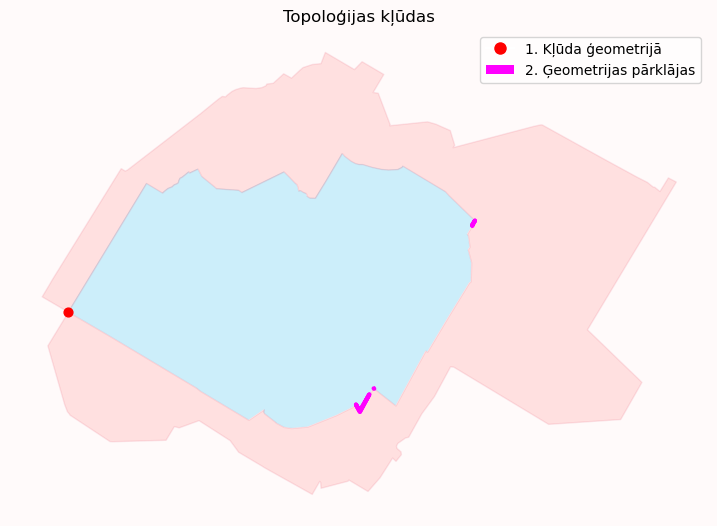

In [17]:
# Izveidoju pārskata karti ar atrastajām topoloģijas kļūdām
# Definēju leģendu un attēloju karti ar numurētām kļūdām

kludas_punkts = [590090.366, 298456.2985]

fig, ax = plt.subplots(figsize=(9,7), facecolor = 'Snow')

kludaina_geometrija = topo[~topo.is_valid]


topo[topo.is_valid].plot(
    ax=ax, 
    color='DeepSkyBlue', 
    alpha=0.2
    )

kludaina_geometrija.plot(
    ax=ax, 
    color='red',
    alpha=0.1,
    linewidth=1,
    edgecolor="Crimson"
    )

parklajumi.plot(
    ax=ax,
    color='Fuchsia', 
    linewidth=3,
    edgecolor="Fuchsia"
    )


ax.scatter(kludas_punkts[0], kludas_punkts[1], color='red', marker='o', s=40)


legend = [
    Line2D([0], [0], marker='o', color='w', label='1. Kļūda ģeometrijā', markerfacecolor='red', markersize=10),
    Patch(facecolor='Fuchsia', label='2. Ģeometrijas pārklājas')
    ]


ax.axis('off')
plt.title('Topoloģijas kļūdas')
ax.legend(handles=legend)
plt.show()

# (3) Meža biotopu statistika valstij piederošās zemēs

#### 1. Izdalu meža biotopus

In [18]:
# Lejupielādēju biotopu telpiskos datus

zip_biotopi = 'biotopi03.zip'

with ZipFile(zip_biotopi, 'r') as archive:
    file_list = archive.namelist()

file_list

['Biotopi/Biotopi.cpg',
 'Biotopi/Biotopi.dbf',
 'Biotopi/Biotopi.prj',
 'Biotopi/Biotopi.sbn',
 'Biotopi/Biotopi.sbx',
 'Biotopi/Biotopi.shp',
 'Biotopi/Biotopi.shp.xml',
 'Biotopi/Biotopi.shx']

In [19]:
# Ielādēju ShapeFile
biotopi = geopandas.read_file(f'zip://{zip_biotopi}!{'Biotopi/Biotopi.shp'}')

C:\Users\igors.liberts\Anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
C:\Users\igors.liberts\Anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Geometry of polygon of fid 78161 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
C:\Users\igors.liberts\Anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Geometry of polygon of fid 117134 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


In [20]:
# Redzot brīdinājumu, izlaboju ģeometriju kļūdas
biotopi['geometry'] = biotopi['geometry'].make_valid()

In [22]:
# Atlasu tikai meža biotopus
meza_bt = biotopi.loc[biotopi['CODE_EC'].str[:1] == '9']
meza_bt.head(3)

,ID,CODE_EC,NAME_EC,VARIANT_EC,STATE,OBS_DATE,GlobalID,FORM_NUMBE,Klase,POLYGON_NU,Shape_Leng,Shape_Area,geometry
1,26386,9010*,Veci vai dabiski boreāli meži,None,0,2007-01-01,{D1B03598-0F05-41AC-8870-1A9E6B14044F},None,None,None,172.770672,1420.227220,"POLYGON ((605225.783 386412.065, 605228.123 38..."
2,26487,9160,"Ozolu meži (ozolu, liepu un skābaržu meži)",None,0,2007-01-01,{9ABC32FA-CA52-4A68-8864-2E1DB5924340},None,None,None,197.664972,1571.761395,"POLYGON ((611775.793 387313.097, 611761.94 387..."
3,26976,9180*,Nogāžu un gravu meži,None,0,2007-01-01,{D4332D2C-5F93-467B-AA7D-6CE74C0D5B3C},None,None,None,365.349995,8603.923231,"POLYGON ((621062.327 394945.19, 621063.324 394..."


#### 2. Valstij piederošas zemes

In [25]:
# Kadastra telpiskos datus lejupielādēju no ArcGIS servisa, jo tie ir ērtāk lietojami nekā Atvērto datu portālā pieejamie

# Ielādēju telpiskos datus par atlasītiem valstij piederošiem zemes īpašumiem
vzemes = geopandas.read_file('Kadastrs_zemes_valsts.gpkg', columns=['geometry'])

In [26]:
# Kaut gan ielādē nebija brīdinājuma, pārbaudu ģeometriju kļūdas
vzemes.loc[~vzemes['geometry'].is_valid].shape[0]

5

In [27]:
# Izlaboju konstatētās ģeometriju kļūdas
vzemes['geometry'] = vzemes['geometry'].make_valid()

#### 3. Veicu aprēķinus

In [28]:
# Ar telpiskās pārklāšanas metodi atlasu meža biotopu teritorijas, kas atrodas valstij piederošās zemēs
mbt_vz = meza_bt.overlay(vzemes, how='intersection', keep_geom_type=True)

In [29]:
# Aprēķinu kopējo meža biotopu platību Latvijā
mbt_kvm = meza_bt['geometry'].area.sum().astype(int)

# Aprēķinu to platību valstij piederošās zemēs
mbt_vz_kvm = mbt_vz['geometry'].area.sum().astype(int)
mbt_vz_ha = (mbt_vz_kvm / 10000).round(3)

# Aprēķinu procentuālo īpatsvaru
mbt_proc = ((mbt_vz_kvm / mbt_kvm) * 100).round(3)

In [30]:
# Izveidoju pārskata tabulu ar rezultātiem

df = pd.DataFrame(
    [mbt_vz_ha.astype(str), 
     mbt_proc.astype(str)], 
    index=['Platība, ha', 'Procentuālais īpatsvars (no to kopējās platības)'], 
    columns=['Meža biotopi valstij piederošās zemēs']
    )

df

,Meža biotopi valstij piederošās zemēs
"Platība, ha",32796.494
Procentuālais īpatsvars (no to kopējās platības),11.768


# (4) Purvu pārskata karte
<br>

Izveidošu interaktīvu tīmekļa karti, īpašu uzmanību pievēršot tās ātrdarbībai, jo kopējais objektu skaits ir ap 2500. Tā kā lielākajai daļai purvu ir vienāds stāvoklis "pastāv" (ko noskaidroju zemāk), atspoguļot to kartē nebūtu pārāk lietderīgi. Līdz ar to lai padarītu karti interesantāku, izveidošu purvu meklētāju pēc piešķirtajiem nosaukumiem, uz kuriem klikšķinot virsū, karte pārvietosies uz konkrētā purva atrašanās vietu.

#### 1. Datu ielāde

In [39]:
# Ielādēju Excel datni
purvi = pd.read_excel('VDB_saraksts.xlsx', header=2)
purvi.head(3)

,Pamatnosaukums,Objekta ID,Objekta veids,Objekta stāvoklis,Oficiālais nosaukums [avota saīsinājums],Citi nosaukumi,Administratīvā vai teritoriālā vienība,Ģeogrāfiskais platums,Ģeogrāfiskais garums
0,Astašovas purvs,12,purvs,pastāv,NaN,Dzeguzes ezers;Zagūzes ezers;Zaguzes ezers;Ast...,"Andrupenes pagasts, Krāslavas novads, agrāk Kr...","56° 07' 21""","27° 22' 11"""
1,Ploču purvs,91,purvs,pastāv,NaN,Ploces purvs;Ploča purvs;Plocis,"Vērgales pagasts, Dienvidkurzemes novads, agrā...","56° 40' 06""","21° 09' 49"""
2,Gobziņu purvs,134,purvs,pastāv,NaN,NaN,"Lažas pagasts, Dienvidkurzemes novads, agrāk L...","56° 48' 22""","21° 23' 07"""


#### 2. Datu apskats un pārbaude

In [40]:
# Pārbaudu ierakstu skaitu
purvi.shape[0]

2485

In [41]:
# Pārbaudu datu kvalitāti – vai koordinātu formāts ir konsekvents

print(purvi['Ģeogrāfiskais platums'].str.len().unique()[0])
print(purvi['Ģeogrāfiskais garums'].str.len().unique()[0])

11
11


In [42]:
# Pārbaudu, vai nav dublētu koordinātu
purvi.loc[purvi.duplicated(['Ģeogrāfiskais platums', 'Ģeogrāfiskais garums'])].shape[0]

0

<Axes: xlabel='Objekta stāvoklis', ylabel='Percent'>

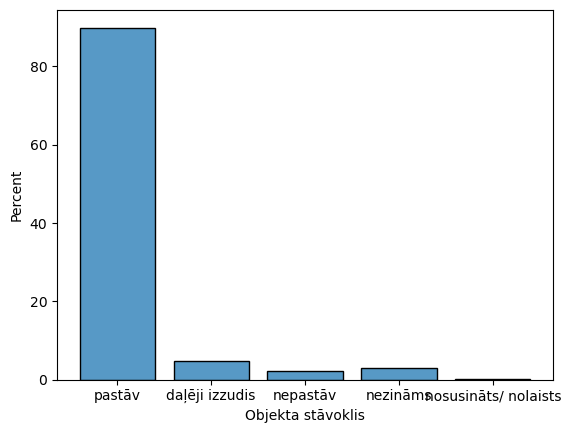

In [43]:
# Apskatu vērtību sadalījumu kolonnā 'Objekta stāvoklis'
sns.histplot(purvi, x='Objekta stāvoklis', stat="percent", shrink=.8)

#### 3. Datu apstrāde

In [44]:
# Konvertēju ģeogrāfiskās koordinātes no DMS uz DD formātu

purvi['lat'] = purvi['Ģeogrāfiskais platums'].str[:2].astype(int) + \
                (purvi['Ģeogrāfiskais platums'].str[4:6].astype(int) / 60) + \
                (purvi['Ģeogrāfiskais platums'].str[8:10].astype(int) / 3600)

purvi['lon'] = purvi['Ģeogrāfiskais garums'].str[:2].astype(int) + \
            (purvi['Ģeogrāfiskais garums'].str[4:6].astype(int) / 60) + \
            (purvi['Ģeogrāfiskais garums'].str[8:10].astype(int) / 3600)

In [45]:
# Izveidoju ģeometriju un pārveidoju datus par GeoDataFrame
purvi['geometry'] = geopandas.points_from_xy(purvi['lon'], purvi['lat'], crs='4326')
purvi = geopandas.GeoDataFrame(purvi, geometry=purvi['geometry'])

# Pārdēvēju nosaukuma kolonnu un atstāju tikai nepieciešamos laukus
purvi = purvi.rename(columns={'Pamatnosaukums': 'name'})
purvi = purvi[['name', 'geometry']]

# Noņemu iespējamās liekās atstarpes no nosaukumiem
purvi['name'] = purvi['name'].str.strip()

purvi.head(3)

,name,geometry
0,Astašovas purvs,POINT (27.36972 56.1225)
1,Ploču purvs,POINT (21.16361 56.66833)
2,Gobziņu purvs,POINT (21.38528 56.80611)


In [46]:
# Saglabāju kā JSON priekš tīmekļa kartes
purvi.to_file('purvi.json', driver="GeoJSON")

#### 4. Kartes izveide

Uz React Leaflet bāzes izstrādāju web karti: [https://latvijas-purvu-karte.vercel.app/](https://latvijas-purvu-karte.vercel.app/)</b>